In [1]:
import vireoSNP
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.io import mmread
from scipy.io import mmwrite
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mquad.mquad_utils import plot_confusionMatrix
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import BinomMixtureVB
from adjustText import adjust_text
print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


## Coverage comparison between Smart-seq2 data and 10x data (Fig. 5a)

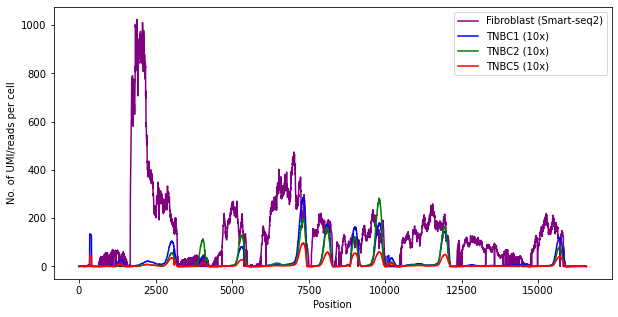

In [3]:
def plot_figure_5a_1():
    tnbc1 = pd.read_csv('TNBC1_data/cellsnp/mquad/BIC_params.csv')
    tnbc1['pos'] = tnbc1.variant_name.apply(lambda x: int(x.split('_')[1]))
    tnbc1_dp = tnbc1.sort_values(by='pos')[['total_DP', 'pos']]

    joxm = pd.read_csv('../fibroblast_joxm/data/mquad/BIC_params.csv')
    joxm['pos'] = joxm.variant_name.apply(lambda x: int(x.split('_')[1]))
    joxm_dp = joxm.sort_values(by='pos')[['total_DP', 'pos']]

    tnbc2 = pd.read_csv('TNBC2_data/cellsnp/mquad/BIC_params.csv')
    tnbc2['pos'] = tnbc2.variant_name.apply(lambda x: int(x.split('_')[1]))
    tnbc2_dp = tnbc2.sort_values(by='pos')[['total_DP', 'pos']]

    tnbc5 = pd.read_csv('TNBC5_data/cellsnp/mquad/BIC_params.csv')
    tnbc5['pos'] = tnbc5.variant_name.apply(lambda x: int(x.split('_')[1]))
    tnbc5_dp = tnbc1.sort_values(by='pos')[['total_DP', 'pos']]

    plt.plot(joxm_dp.pos, joxm_dp.total_DP/77, color='purple', label="Fibroblast (Smart-seq2)")
    plt.plot(tnbc1_dp.pos, tnbc1_dp.total_DP/1097, color='blue', label="TNBC1 (10x)")
    plt.plot(tnbc2_dp.pos, tnbc2_dp.total_DP/1034, color='green', label="TNBC2 (10x)")
    plt.plot(tnbc5_dp.pos, tnbc5_dp.total_DP/3225, color='red', label="TNBC5 (10x)")
    plt.xlabel('Position')
    plt.ylabel('No. of UMI/reads per cell')
    plt.legend(loc='upper right')

fig = plt.figure(figsize=(10,5))
plot_figure_5a_1()

ss data loaded
scRNA data loaded
...scRNA done
...ssRNA done


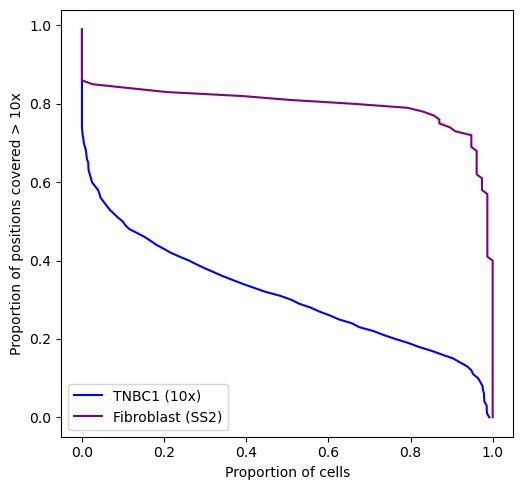

In [4]:
cell_vcf = vireoSNP.load_VCF("../fibroblast_joxm/data/cellsnp/cellSNP.cells.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

#AD = cell_dat['AD']
ssRNA_DP = cell_dat['DP']
#variants=cell_vcf['variants']
print('ss data loaded')

cell_vcf = vireoSNP.load_VCF("TNBC1_data/cellsnp/cellSNP.cells.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

scRNA_DP = cell_dat['DP']
print('scRNA data loaded')


#percentage of cells with percentage of positions covered > 10x
prop_pos_scRNA = [scRNA_DP[:,i][scRNA_DP[:,i] >= 10].shape[1]/scRNA_DP.shape[0] for i in range(scRNA_DP.shape[1])]
print('...scRNA done')

prop_pos_ssRNA = [ssRNA_DP[:,i][ssRNA_DP[:,i] >= 10].shape[1]/ssRNA_DP.shape[0] for i in range(ssRNA_DP.shape[1])]
print('...ssRNA done')

prop_rna = np.array(prop_pos_scRNA)
prop_ssrna = np.array(prop_pos_ssRNA)
prop_cells_scRNA = [len(prop_rna[prop_rna > i/100])/len(prop_pos_scRNA) for i in range(100)]
prop_cells_ssRNA = [len(prop_ssrna[prop_ssrna > i/100])/len(prop_pos_ssRNA) for i in range(100)]

def plot_figure_5a_2(ax):
    ax.plot(prop_cells_scRNA, np.array(range(100))/100, color='b', label="TNBC1 (10x)")
    ax.plot(prop_cells_ssRNA, np.array(range(100))/100, color='purple', label="Fibroblast (SS2)")
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    plt.xlabel('Proportion of cells')
    plt.ylabel('Proportion of positions covered > 10x')
    plt.legend(loc = 'lower left')
    plt.tight_layout()

plt.style.use('default')
fig = plt.figure(figsize=(10,5), dpi=100)
ax = plt.subplot(1, 2, 1)
plot_figure_5a_2(ax)


## Assign clones with vireoSNP
Here we assign cells to clones based on mtDNA mutations found by MQuad. Although there are only 2 variants found due to sparsity of 10x dataset, vireo still confidently assigns a good proportion of cells into 2 clones.

In [5]:
#read in output from MQuad

AD = mmread('TNBC1_data/cellsnp/mquad/passed_ad.mtx').tocsc()
DP = mmread('TNBC1_data/cellsnp/mquad/passed_dp.mtx').tocsc()

AD.shape, DP.shape

((2, 1097), (2, 1097))

In [11]:
_model = BinomMixtureVB(n_var=len(AD.getnnz(axis=1)), n_cell=len(AD.getnnz(axis=0)), n_donor=2)
_model.fit(AD, DP, min_iter=30, n_init=300)

modelCA = _model

We also want to compare the clonal assignment to the CNV clone labels published in the copyKAT paper (Gao. et al, 2021). To save some time, the labels have already been downloaded and processed so we just need to read these in.

In [22]:
with open('TNBC1_data/cellsnp/cellSNP.samples.tsv', 'r') as f:
    sample_id = f.read().splitlines()

with open('TNBC1_data/tumor_label.txt', 'r') as f:
    tumor = f.read().splitlines()

conf = []
for i in modelCA.ID_prob:
    if max(i) >= 0.8:
        conf.append('True')
    else:
        conf.append('False')
        
clone_id = np.argmax(modelCA.ID_prob, axis=1)

clones_df = pd.DataFrame(data={'sample_id':sample_id, 'clone_id':clone_id, 'confident':conf, 'tumor':tumor})

In [23]:
copykat = pd.read_csv('TNBC1_data/TNBC1_copykat.txt', sep='\t', header=None)
clones_df = pd.concat([clones_df, copykat], axis=1, ignore_index=True)
clones_df = clones_df.rename({0: 'sample_id', 1: 'clone_id', 2:'confident', 3:'tumor', 4:'copykat'}, axis='columns')

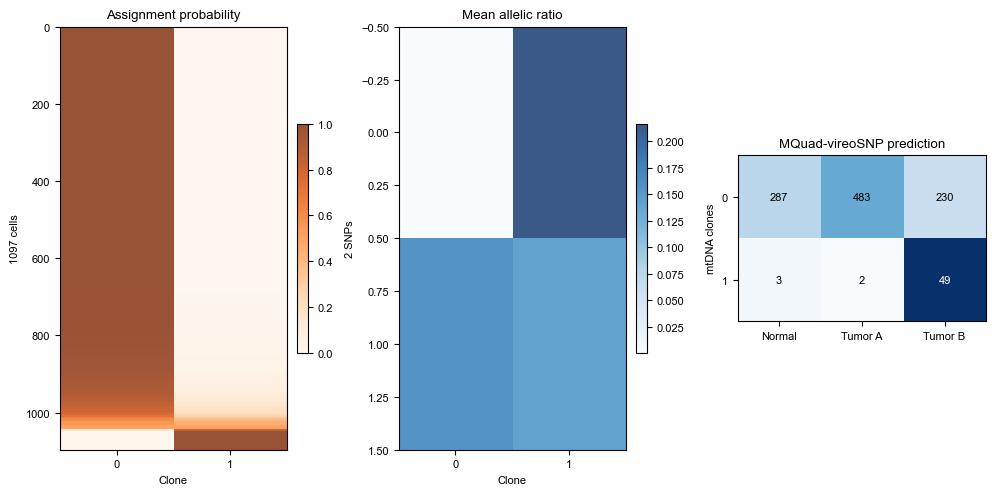

In [25]:
def plot_figure_5b_assignment(modelCA):
    im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Assignment probability")
    plt.xlabel("Clone")
    plt.ylabel("%d cells" %(modelCA.n_cell))
    plt.xticks(range(modelCA.n_donor))
    plt.tight_layout()

def plot_figure_5b_AF(modelCA):
    im = heat_matrix(modelCA.beta_mu, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Mean allelic ratio")
    plt.xlabel("Clone")
    plt.ylabel("%d SNPs" %(modelCA.n_var))
    plt.xticks(range(modelCA.n_donor))
    plt.tight_layout()

def plot_figure_5c(ax):
    #if it throws an error, try quotations around True
    confusion = pd.crosstab(clones_df[clones_df.confident == 'True']['copykat'], clones_df[clones_df.confident == 'True']['clone_id'], rownames=['copyKAT clusters'], colnames=['MT clones'])
    confusion = confusion.reindex([2,1,3])
    #confusion = np.transpose(confusion)
    plot_confusionMatrix(confusion.T, ax)
    plt.title('MQuad-vireoSNP prediction')
    plt.ylabel('mtDNA clones')
    plt.xticks(range(3), ['Normal', 'Tumor A', 'Tumor B']) #, rotation=315)
    plt.yticks(range(2), set(clones_df.clone_id))
    plt.tight_layout()

fig = plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plot_figure_5b_assignment(modelCA)

plt.subplot(1,3,2)
plot_figure_5b_AF(modelCA)

ax=plt.subplot(1,3,3)
plot_figure_5c(ax)


In [26]:
## save clone_id for later use
clones_df.to_csv('TNBC1_data/clones_df.csv')

In [27]:
## read in umap coords from Seurat

#uncomment the following line to save time and reproduce results
#clones_df = pd.read_csv('TNBC1_data/clones_df.csv')
umap = pd.read_csv('TNBC1_data/TNBC1_UMAP.csv', index_col=0)

## combine it with clones_df into a single df with Tumor only
clones_df.index = clones_df.sample_id.str.replace('-1', '')
t_only = clones_df[clones_df.tumor == 'T']

tumor_umap = pd.concat([umap, t_only], axis=1)
#tumor_umap = tumor_umap.rename({0:'UMAP_1', 1:'UMAP_2',2: 'sample_id', 3: 'clone_id', 4:'confident', 5:'tumor', 6:'copykat'}, axis='columns')

tumor_umap.head()

,UMAP_1,UMAP_2,sample_id,clone_id,confident,tumor,copykat
AAACCTGCACCTTGTC,0.565882,2.175423,AAACCTGCACCTTGTC-1,0,True,T,1
AAACGGGTCCAGAGGA,5.648374,-3.764367,AAACGGGTCCAGAGGA-1,0,True,T,1
AAAGATGCAGTTTACG,-7.729216,3.903321,AAAGATGCAGTTTACG-1,0,True,T,3
AAAGCAACAGGAATGC,4.931745,-1.496624,AAAGCAACAGGAATGC-1,0,True,T,1
AAAGCAATCGGAATCT,-3.595340,2.902084,AAAGCAATCGGAATCT-1,0,True,T,3


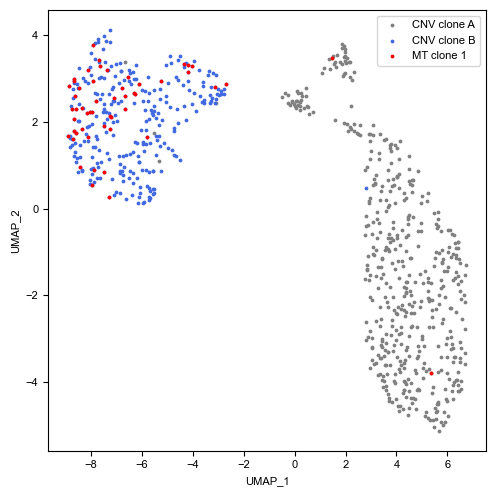

In [28]:
fig = plt.figure(figsize=(5,5))
def plot_figure_5d():
    plt.scatter(tumor_umap.UMAP_1[tumor_umap.copykat == 1], tumor_umap.UMAP_2[tumor_umap.copykat == 1], s=3, color='grey', label="CNV clone A")
    plt.scatter(tumor_umap.UMAP_1[tumor_umap.copykat == 3], tumor_umap.UMAP_2[tumor_umap.copykat == 3], s=3, color='royalblue', label="CNV clone B")
    plt.scatter(tumor_umap.UMAP_1[tumor_umap.clone_id == 1], tumor_umap.UMAP_2[tumor_umap.clone_id == 1], s=3, color='red', label="MT clone 1")
    plt.xlabel('UMAP_1')
    plt.ylabel('UMAP_2')
    plt.legend()
    plt.tight_layout()

plot_figure_5d()
#plt.savefig('figures/UMAP.png', dpi=300)

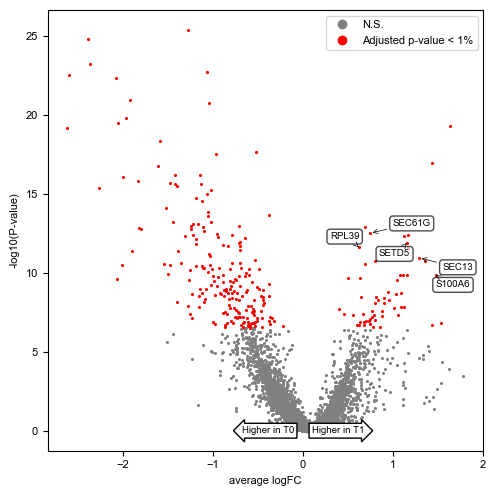

In [29]:
## read in DE results from Seurat
def plot_figure_5e():
    de_tab = pd.read_csv('TNBC1_data/TNBC1_t1_markers.csv', index_col = 0)

    de_tab_sig = de_tab[de_tab.p_val_adj < 0.01]
    de_tab_not_sig = de_tab[de_tab.p_val_adj >= 0.01]

    plt.scatter(de_tab_not_sig.avg_log2FC, -np.log10(de_tab_not_sig.p_val), color = 'grey', label = 'N.S.', s=1.5)
    plt.scatter(de_tab_sig.avg_log2FC, -np.log10(de_tab_sig.p_val), color='r', label = 'Adjusted p-value < 1%', s=1.5)
    legend_elements = [Line2D([0], [0], marker = 'o', color = 'grey', label = 'N.S.', linestyle = 'None'),
    Line2D([0], [0], marker = 'o', color = 'r', label = 'Adjusted p-value < 1%', linestyle = 'None')]
    plt.legend(handles = legend_elements)
    plt.text(-0.1, 0, 'Higher in T0', ha='right', va='center', bbox = dict(boxstyle="larrow", fc='white', lw=1), fontsize = 7)
    plt.text(0.1, 0, 'Higher in T1', ha='left', va='center', bbox = dict(boxstyle="rarrow", fc='white', lw=1), fontsize = 7)
    plt.xlabel('average logFC')
    plt.ylabel('-log10(P-value)')

    texts=[]
    lab_list = ['SEC13', 'RPL39', 'SEC61G', 'SETD5', 'S100A6']
    props = dict(boxstyle='round', alpha = 0.7, facecolor='white')
    for i in lab_list:
        x = de_tab.loc[i,'avg_log2FC']
        y = -np.log10(de_tab.loc[i,'p_val'])
        texts.append(plt.text(x,y,i, fontsize = 7, bbox=props))

    adjust_text(texts, force_text = 0.5 , force_points = 0.5, expand_points=(1, 2), expand_text=(1.5, 1.5), arrowprops = dict(arrowstyle="->", color='black', lw=0.5))
    plt.tight_layout()

fig = plt.figure(figsize=(5,5))
plot_figure_5e()
#plt.savefig('figures/DE.png', dpi=300)

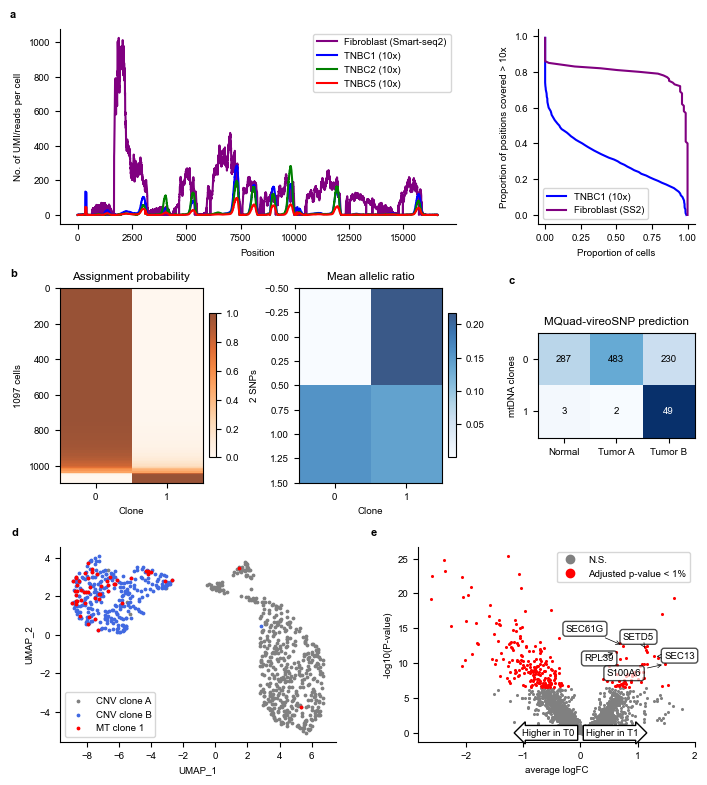

In [32]:
#put everything tgt

import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text
plt.ion()
plt.style.use('default')
font = {'family' : 'Arial',
        'size'   : 7}
plt.rc('font', **font)
cm = 1/2.54
fig = plt.figure(figsize=(18*cm, 20*cm), dpi=100)
fig_grid_r = 6
fig_grid_c = 6

#compare scRNA-seq data coverage
ax2 = plt.subplot2grid((fig_grid_r, fig_grid_c), (0, 0), colspan=4, rowspan=2)
plot_figure_5a_1()
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


ax3 = plt.subplot2grid((fig_grid_r, fig_grid_c), (0, 4), colspan=2, rowspan=2)
plot_figure_5a_2(ax3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)


ax4 = plt.subplot2grid((fig_grid_r, fig_grid_c), (2, 0), colspan=2, rowspan=2)
plot_figure_5b_assignment(modelCA)

ax_af = plt.subplot2grid((fig_grid_r, fig_grid_c), (2, 2), colspan=2, rowspan=2)
plot_figure_5b_AF(modelCA)

ax5 = plt.subplot2grid((fig_grid_r, fig_grid_c), (2, 4), colspan=2, rowspan = 2)
plot_figure_5c(ax5)

ax7 = plt.subplot2grid((fig_grid_r, fig_grid_c), (4, 0), colspan=3, rowspan = 2)
plot_figure_5d()
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

ax6 = plt.subplot2grid((fig_grid_r, fig_grid_c), (4, 3), colspan=3, rowspan = 2)
plot_figure_5e()
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)


draw_text=True
if draw_text: 
    ax2.text(-0.11, 1.1, 'a', transform = ax2.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
    ax4.text(-0.3, 1.1, 'b', transform = ax4.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
    ax6.text(-0.15, 1.1, 'e', transform = ax6.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
    ax5.text(-0.15, 1.55, 'c', transform = ax5.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
    ax7.text(-0.15, 1.1, 'd', transform = ax7.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')

fig.tight_layout()

plt.savefig('figures/Fig5.pdf')